# Phase 2: Classification Prediction with Imbalanced Target

# Mary Donovan Martello

**Phase 1 of the credit card default project involved testing five binary classification models for predicting credit card defaults.  Phase 1 can be found:** [here](https://github.com/MaryDonovanMartello/Credit-Card-Default-Prediction)

**Phase 2 of the credit card default project includes (1) employing methodologies other than Principal Component Analysis to address multicollinearity and feature selection in an effort to be able to analyze individual factors that are significant for defaults, (2) testing multiple approaches to addressing an imbalanced target variable in a binary classification model, and (3) implementing deployment models to make actual predictions and convert the logistic regression coefficients to a risk score that can be used in making lending decisions.**

## Part 7:  Approach to Imbalance:  Over and Undersample Training Data in imblearn Pipeline

In [2]:
# import libraries

import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import mean
from numpy import std
from numpy import argmax
from numpy import where

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score, recall_score, average_precision_score, auc, precision_recall_curve, log_loss

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline


#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')




### This notebook uses two datasets that were cleaned and prepared in the 1_EDA_Prep notebook.  One of the datasets replaces some of the original variables with the Months_Late engineered features and the second dataset replaces some of the original variables with both the Months_Late and Payment_Ratio engineered features.

In [3]:
# Load data into a dataframe

df1 = pd.read_csv('logDefaultRev1.csv')
df2 = pd.read_csv('logDefaultRev2.csv')

In [4]:
df1.head()

,default,SEX,EDUCATION,MARRIAGE,AGE,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MONTHS_LATE
0,1,1,1,2,3.401197,10.819798,12.157764,11.451880,12.121908,12.185186,11.599122,12.815479,0.000000,7.901377,0.000000,7.707962,7.090910,0.000000,1.94591
1,1,1,2,2,3.401197,12.676079,12.318723,11.767754,12.289720,12.339830,11.875079,12.907014,7.824446,7.824446,0.000000,8.476580,7.783641,7.378384,1.94591
2,1,1,1,1,3.988984,12.206078,12.623996,12.257488,12.610621,12.657464,12.339112,13.100394,8.748464,8.612685,8.612685,8.612685,8.517393,8.517393,1.94591
3,0,2,2,2,3.295837,11.002117,12.311630,11.735957,12.285069,12.346786,11.826144,12.886411,0.000000,8.517393,7.828835,1.945910,8.006701,8.006701,1.94591
4,0,1,2,1,3.737670,12.542548,12.615709,12.246783,12.584776,12.658428,12.360976,13.100157,8.779711,0.000000,9.564863,9.605822,0.000000,8.517393,1.94591


In [5]:
df1.shape

(30000, 19)

In [6]:
df1.columns

Index(['default', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'MONTHS_LATE'],
      dtype='object')

In [7]:
df2.head()

,default,SEX,EDUCATION,MARRIAGE,AGE,LIMIT_BAL,MONTHS_LATE,PAYMENT_RATIO
0,1,1,1,2,3.401197,10.819798,1.94591,0.038110
1,1,1,2,2,3.401197,12.676079,1.94591,0.037397
2,1,1,1,1,3.988984,12.206078,1.94591,0.037338
3,0,2,2,2,3.295837,11.002117,1.94591,0.038758
4,0,1,2,1,3.737670,12.542548,1.94591,0.046396


In [8]:
df2.shape

(29130, 8)

In [9]:
df2.columns

Index(['default', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL',
       'MONTHS_LATE', 'PAYMENT_RATIO'],
      dtype='object')

**Create feature dataframes for modeling.**

In [10]:
#df1

# separate into input and output columns (X variable for features and y for target variables)

X1 = df1.drop('default', axis = 1)
y1 = df1['default']

In [11]:
y1.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [30]:
#df1 subset

# separate into input and output columns (X variable for features and y for target variables)

X1s = df1.loc[:, ['MONTHS_LATE', 'LIMIT_BAL', 'AGE']] 
y1s = df1['default']

In [13]:
#df2

# separate into input and output columns (X variable for features and y for target variables)

X2 = df2.drop('default', axis = 1) 
y2 = df2['default']

In [14]:
y2.value_counts()

0    22811
1     6319
Name: default, dtype: int64

In [31]:
#df2 subset

# separate into input and output columns (X variable for features and y for target variables)

X2s = df2.loc[:, ['MONTHS_LATE', 'PAYMENT_RATIO',]] 
y2s = df2['default']

**Split the data.**

In [16]:
# separate data into training and test data
X1Train, X1Test, y1Train, y1Test = train_test_split(X1, y1, test_size =0.2, random_state=1)

# one-hot encode input categorical variables

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [0, 1, 2])], remainder='passthrough')
X1Train = transformer.fit_transform(X1Train)


In [25]:
# separate data into training and test data
X2Train, X2Test, y2Train, y2Test = train_test_split(X2, y2, test_size =0.2, random_state=1)

# one-hot encode input categorical variables
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [0, 1, 2])], remainder='passthrough')
X2Train = transformer.fit_transform(X2Train)


In [32]:
# separate data into training and test data
X1sTrain, X1sTest, y1sTrain, y1sTest = train_test_split(X1s, y1s, test_size =0.2, random_state=1)

In [33]:
# separate data into training and test data
X2sTrain, X2sTest, y2sTrain, y2sTest = train_test_split(X2s, y2s, test_size =0.2, random_state=1)

**Modeling - Over and Under Sample**

In [ ]:
#  it is believed that SMOTE performs better when combined with undersampling of the majority class, such as random undersampling

**Pipeline to scale and oversample data and tune a Logistic Regression model.**

In [18]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# define resampling
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

# define pipeline
trans = StandardScaler()
model = LogisticRegression()
pipeline = Pipeline(steps=[('t', trans), ('r', resample), ('m', model)])

# set paramaters to be tested in the grid search
params = {'m__C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'm__penalty': ['l1', 'l2']}

# set cross-validation technique
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# tune the model
lrTomek_grid=GridSearchCV(pipeline, params, verbose=2,
          cv=skf, scoring={'avr': make_scorer(recall_score, needs_proba=False),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, 
                    refit='avr', n_jobs=-1)



**Fit model for 4 different subsets of data**

In [19]:
# X1 df
# fit the tuned model
lrTomek_grid.fit(X1Train, y1Train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('t', StandardScaler(copy=True, with_mean=True, with_std=True)), ('r', SMOTETomek(random_state=None, ratio=None, sampling_strategy='auto',
      smote=None,
      tomek=TomekLinks(n_jobs=1, random_state=None, ratio=None, return_indices=False,
      sampling_strategy='majority'))), ('m', Logis...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'m__C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'm__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [26]:
# X2 df
# fit the tuned model
lrTomek_grid.fit(X2Train, y2Train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('t', StandardScaler(copy=True, with_mean=True, with_std=True)), ('r', SMOTETomek(random_state=None, ratio=None, sampling_strategy='auto',
      smote=None,
      tomek=TomekLinks(n_jobs=1, random_state=None, ratio=None, return_indices=False,
      sampling_strategy='majority'))), ('m', Logis...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'m__C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'm__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [38]:
# X1 df subset
# fit the tuned model
lrTomek_grid.fit(X1sTrain, y1sTrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('t', StandardScaler(copy=True, with_mean=True, with_std=True)), ('r', SMOTETomek(random_state=None, ratio=None, sampling_strategy='auto',
      smote=None,
      tomek=TomekLinks(n_jobs=1, random_state=None, ratio=None, return_indices=False,
      sampling_strategy='majority'))), ('m', Logis...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'m__C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'm__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [42]:
# X2 df subset
# fit the tuned model
lrTomek_grid.fit(X2sTrain, y2sTrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('t', StandardScaler(copy=True, with_mean=True, with_std=True)), ('r', SMOTETomek(random_state=None, ratio=None, sampling_strategy='auto',
      smote=None,
      tomek=TomekLinks(n_jobs=1, random_state=None, ratio=None, return_indices=False,
      sampling_strategy='majority'))), ('m', Logis...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'m__C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'm__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [23]:
# save the model to a file
#import joblib
# filename = 'TrainTest1model.sav'  
# joblib.dump(lr_grid, filename)

**Evaluate Predictions**

<AxesSubplot:>

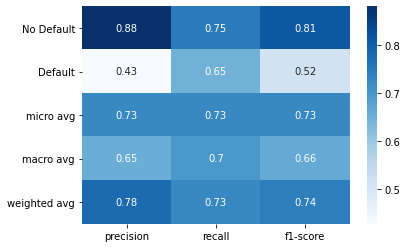

In [22]:
# predictions X1 df
y1Pred = lrTomek_grid.predict(X1Test)

TomekCR = classification_report(y1Test, y1Pred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(TomekCR).iloc[:-1, :].T, annot=True, cmap="Blues")

In [23]:
TomekCR

{'No Default': {'precision': 0.8813303099017384,
  'recall': 0.7508048937540245,
  'f1-score': 0.8108484005563282,
  'support': 4659},
 'Default': {'precision': 0.42836041358936483,
  'recall': 0.6487695749440716,
  'f1-score': 0.5160142348754448,
  'support': 1341},
 'micro avg': {'precision': 0.728,
  'recall': 0.728,
  'f1-score': 0.728,
  'support': 6000},
 'macro avg': {'precision': 0.6548453617455516,
  'recall': 0.6997872343490481,
  'f1-score': 0.6634313177158866,
  'support': 6000},
 'weighted avg': {'precision': 0.7800915380759229,
  'recall': 0.728,
  'f1-score': 0.7449529645266508,
  'support': 6000}}

<AxesSubplot:>

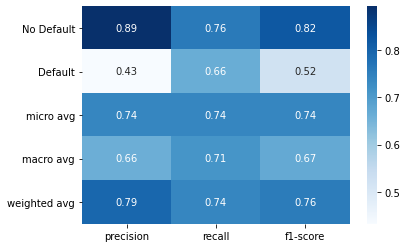

In [28]:
# predictions X2 df
y2Pred = lrTomek_grid.predict(X2Test)

TomekCR2 = classification_report(y2Test, y2Pred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(TomekCR2).iloc[:-1, :].T, annot=True, cmap="Blues")

In [29]:
TomekCR2

{'No Default': {'precision': 0.8930946291560102,
  'recall': 0.7624454148471616,
  'f1-score': 0.8226148409893992,
  'support': 4580},
 'Default': {'precision': 0.4321503131524008,
  'recall': 0.6645264847512039,
  'f1-score': 0.523719165085389,
  'support': 1246},
 'micro avg': {'precision': 0.741503604531411,
  'recall': 0.741503604531411,
  'f1-score': 0.7415036045314111,
  'support': 5826},
 'macro avg': {'precision': 0.6626224711542055,
  'recall': 0.7134859497991828,
  'f1-score': 0.6731670030373941,
  'support': 5826},
 'weighted avg': {'precision': 0.7945129920567144,
  'recall': 0.741503604531411,
  'f1-score': 0.7586903624146658,
  'support': 5826}}

<AxesSubplot:>

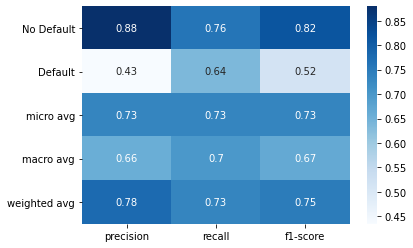

In [40]:
# predictions X1 df subset
y1sPred = lrTomek_grid.predict(X1sTest)

TomekCR1s = classification_report(y1sTest, y1sPred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(TomekCR1s).iloc[:-1, :].T, annot=True, cmap="Blues")

In [41]:
TomekCR1s

{'No Default': {'precision': 0.8794941730721547,
  'recall': 0.7613221721399442,
  'f1-score': 0.8161527841693512,
  'support': 4659},
 'Default': {'precision': 0.43467208947635994,
  'recall': 0.6375838926174496,
  'f1-score': 0.5169286577992744,
  'support': 1341},
 'micro avg': {'precision': 0.7336666666666667,
  'recall': 0.7336666666666667,
  'f1-score': 0.7336666666666666,
  'support': 6000},
 'macro avg': {'precision': 0.6570831312742573,
  'recall': 0.6994530323786969,
  'f1-score': 0.6665407209843128,
  'support': 6000},
 'weighted avg': {'precision': 0.7800764373884946,
  'recall': 0.7336666666666667,
  'f1-score': 0.7492761919256391,
  'support': 6000}}

<AxesSubplot:>

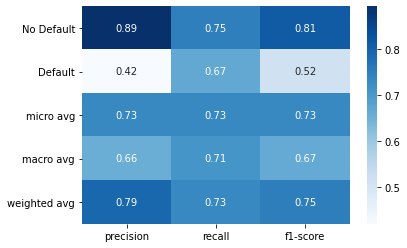

In [44]:
# predictions X2 df subset
y2sPred = lrTomek_grid.predict(X2sTest)

TomekCR2s = classification_report(y2sTest, y2sPred, output_dict=True, target_names= ['No Default', 'Default'])

# Create a dataframe from the dictionary and plot a heatmap of it.
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(TomekCR2s).iloc[:-1, :].T, annot=True, cmap="Blues")

In [45]:
TomekCR2s

{'No Default': {'precision': 0.8926436184039511,
  'recall': 0.7497816593886463,
  'f1-score': 0.8149994066690399,
  'support': 4580},
 'Default': {'precision': 0.42091965639211726,
  'recall': 0.6685393258426966,
  'f1-score': 0.5165891472868216,
  'support': 1246},
 'micro avg': {'precision': 0.7324064538276691,
  'recall': 0.7324064538276691,
  'f1-score': 0.7324064538276691,
  'support': 5826},
 'macro avg': {'precision': 0.6567816373980342,
  'recall': 0.7091604926156714,
  'f1-score': 0.6657942769779308,
  'support': 5826},
 'weighted avg': {'precision': 0.7917565506616331,
  'recall': 0.7324064538276691,
  'f1-score': 0.7511787435742503,
  'support': 5826}}

In [24]:
# save the model to a file
import joblib
filename = 'OverUnderModel.sav'
joblib.dump(lrTomek_grid, filename)

['OverUnderModel.sav']